In [2]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


###The Effect of Noise Correlations in Populations of Diversely Tuned Neurons

Ecker et al. (2011) *Journal of Neuroscience*

Both papers examine the impact of correlated variability on neuronal coding by making use of a metric called Fisher Information. The Fisher Information provides a lower bound on the variance that an unbiased estimator of a signal can achieve, telling us what, theoretically, our best case unbiased estimate would be. An estimator is *unbiased* in the case that $E[\hat{\theta}] = \theta$, where $\theta$ is the parameter or signal we are trying to estimate. We will soon become even better acquainted with the concept of Fisher Information, but first let's introduce the basic models assumed by both authors to position ourselves to better appreciate the results that follow from the information theoretic analysis.

We have a population of $n$ neurons that respond to a stimulus $\theta \in [0, 2\pi)$. The response of neuron $j$ is 

$$
y_j(\theta) = f_j(\theta) + \eta_j(\theta)
$$

where $f_j(\theta)$ is the tuning curve and $\eta(\theta)$ is the trial-to-trial variability in the response of neuron $j$. As will be familiar by now, we are taking the joint response of the population to follow a multivariate Gaussian distribution with covariance $\mathbf{Q(\theta)}$, giving

$$
P(\mathbf{r}|\theta) = Z^{-1}\exp\left(-\frac{1}{2}{(\mathbf{r} - \mathbf{f(\theta)})\mathbf{Q(\theta)}^{-1}(\mathbf{r} - \mathbf{f(\theta)})}\right)
$$

Two points should be made regarding the tuning functions $f_j(\theta)$ and the form of $\mathbf{Q(\theta)}$.

The **tuning curves** are uniformly spaced around the circle so that the preferred orientation or direction of motion, $\phi_j = 2\pi{j}/n$, where $j$ ranges from $0$ to $n-1$ or equivalently from $-n/2$ to $n/2$. In both cases tuning curves take the following form:

$$
f_j(\theta) = \alpha + \beta\exp\left({\gamma[(cos(\theta - \phi_j) - 1]}\right)
$$

The first way in which the two models differ is with respect to the heterogeneity of the tuning curves in the population. 

In the model from Sompolinsky et al. (2001), the tuning curves are homogeneous and vary only in their preferred stimulus value, such that

$$
f_j(\theta) = f(\theta - \phi_j),
$$

whereas in Ecker et al. (2011), in one condition, tuning curve amplitudes were allowed to vary, such that

$$
f_j(\theta) = a_jf(\theta - \phi_j),
$$

and in another condition, $\alpha, \beta$, and $\gamma$ were varied.

Below we define a general function for producing tuning curves according to the above model for $f_j(\theta)$.

In [11]:
def tc(alpha, beta, gamma, theta, phi): # Generate tuning curve examples
    f = alpha + beta*exp(gamma*(cos(theta-phi)-1))
    return f


In the figure below we plot some example *homogeneous* tuning curves of the type used in Sompolinsky et al. (2001), meaning they vary only in their preferred direction, so $a, \alpha, \beta$ and $\gamma$ are all constant.

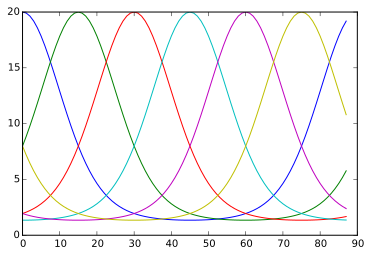

In [16]:
thetas = arange(0,175,2)*2*pi/180
phi = arange(0,180,30)*2*pi/180
for i in phi:
    f = tc(1,19,2, thetas, phi[i])
    plot(f)

Now we generate some example tuning curves with amplitude heterogeneity. In this case we simply multiply the output of our tuning curve function with some scalar.

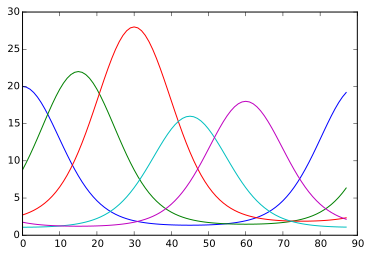

In [17]:
thetas = arange(0,175,2)*2*pi/180
phi = arange(0,180,30)*2*pi/180
amps = [1,1.1,1.4,0.8,0.9,1.3]
idx = arange(0,5,1)
for i in idx:
    f = tc(1,19,2, thetas, phi[i])
    plot(amps[i]*f)

These tuning figures above are analagous to Fig 1E and 1J in Ecker et al. (2011).

Having just dealt with the form of the $\mathbf{f(\theta)}$ in our population model discussed above, let us turn to the **covariance structure** and our $\mathbf{Q(\theta)}$ term from our above model.

We can write $\mathbf{Q(\theta)}$ in the following manner:

$$
\mathbf{Q(\theta)} = \mathbf{S(\theta)RS(\theta)}
$$
or, elementwise as
$$
Q_{jk}(\theta) = \sigma_j(\theta)\sigma_k(\theta)r_{jk}
$$

As mentioned at the end of the last section, the type of correlation structure we will be dealing with now is called a *Limited Range Structure*, and what this means becomes clearer upon closer examination of the correlation matrix $\mathbf{R}$. Limited range correlations, or LRCs, refer to a pattern of correlations where the strength of the correlation coefficient depends on how similar the tuning preferences of the two neurons in the pair are. We can give this idea an explicit form as follows:

$$
r_{jk} = c(|\phi_j \ominus \phi_k|) + \delta(1-c(0))
$$

Here, the $\ominus$ symbol refers to the angular difference between the two stimulus preferences $\phi_j$ and $\phi_k$. In a limited range structure, neurons with more similar tuning preferences are more strongly correlated, so the exact parameterization of our angular difference is as follows:

$$
c(|\phi_j \ominus \phi_k|) = c_0\exp\left(\frac{-|\phi_j \ominus \phi_k|}{L}\right)
$$

Let's take a closer look at the resulting structure.

In [59]:
def lrc(diffs, c_0, L):
    return c_0*exp(-diffs/L)

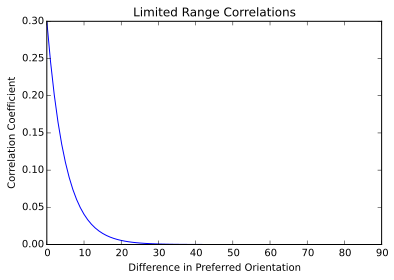

In [60]:
dPhi = arange(0,90,1)
L = 5
c_0 = .3
c = lrc(dPhi, c_0, L)
plot(dPhi,c)
xlabel('Difference in Preferred Orientation')
ylabel('Correlation Coefficient')
title('Limited Range Correlations')

From the above we can see that as the difference in preferred orientation of the two neurons in the pair increases, the correlation coefficient decreases.

As we saw above in our definition of $\mathbf{Q(\theta)}$, we made the variance of the neuronal responses, $\sigma_j^2(\theta)$, stimulus dependent, and in Ecker et al. (2011), the noise is *Poisson-like*, such that $\sigma_j^2(\theta) = f_j(\theta)$. This parameterization of the variance is called "proportional noise" (following Wilke and Eurich, 2002), whereas a stimulus independent variance $\sigma_j$ is the "additive noise" case we have already seen, as treated in Sompolinsky et al. 2001. 

Thus, we can already begin to appreciate a number of subtleties regarding these models, and therefore regarding how correlations relate to population coding. In particular, we will see that:

1. The choice of tuning curves being *homogeneous* or *heterogeneous*, and 
2. The choice of noise structure (i.e, additive versus proportional)

can have an important impact on population coding. In order to see this we will use the concept of Fisher Information, which we are now in a position to define more thoroughly and explore in the context of our model elaborated above.

**Fisher Information**

We are interested in how well we can estimate the value of a particular parameter based on neuronal population activity. Remember, ultimately we want to know how different patterns of correlations we see in real data might effect the quality of a population code. We don't know what sort of code neurons use, so we tackle the problem from a theoretical standpoint, and fortunately there is a good deal of work on the problem of parameter estimation. 

Let's take the example of a single neuron to help make this discussion more concrete. Our neuron will prefer orientations of $90^\circ$. We have a model for our neuron's mean firing rates in response to various stimulus orientations, which is the tuning curve shown above. In line with the model we've been working with, we assume that there is some variability around these mean rates, which happens to be Gaussian distributed. Then we can write out neuron's firing rate in the following manner (as we have been doing):

$$ 
r(\theta) = f(\theta) + \eta,
$$

where $\eta \sim \mathcal{N}(0, \sigma^2)$. Now because we have knowledge of the neuron's tuning curve, our task is to estimate the underlying mean rate, which we can then use to determine the orientation that was likely shown (although strictly speaking this is not a great example since, given the symmetry of our neuron's tuning curve, there would be two possible orientations that could elicit a particular mean firing rate, assuming we are not dealing with the peak firing rate. We can pretend that this is not the case).

In order to estimate, we need an estimator (for example, the sample mean of realizations of a random variable). However, as we said before, we are not sure how neurons perform this estimation, so we analyze what, in theory, is the best performance an estimator could achieve under certain circumstances (for example, additive versus proportional noise, or homogeneous versus heterogeneous tuning curves). 

This "best performance" case is called the *Cramer-Rao Lower Bound (CRLB)*, which is the minimum variance of an unbiased estimator of a particular parameter.  Specifically, this variance is bounded in the following manner:

$$
var(\hat{\theta}) \geq \frac{1}{-E\Big[\frac{\partial^2 ln p(x; \theta)}{\partial \theta^2}\Big]} = \frac{1}{I(\theta)}.
$$

In our case we would replace $x$ in $p(x;\theta)$ with $r$. The quantity in the denominator is the Fisher Information, which in the papers we are discussing is referenced by $J$. Thus, the minimum variance an unbiased estimator can achieve is the inverse of the Fisher Information of a random variable, for example $r$, about a parameter $\theta$. To put this another way, if we can calculate the Fisher Information, we know what the best possible scenario is for the performance of an estimator. 

*Fisher Information with Independent Neurons under Additive Gaussian Noise*

To demonstrate this, let's examine the case where all of our neurons are independent. We will otherwise assume the same multivariate Gaussian noise model as above (the difference is that $\mathbf{Q}(\theta)$ is diagonal, and each diagonal element is equalt to $\sigma^2$. Our likelihood function then is 

$$
P(\mathbf{r}|\theta) = \frac{1}{(2\pi\sigma^2)^\frac{N}{2}}\exp\left(-\frac{1}{2\sigma^2}\sum_i(r_i - f_i(\theta))^2\right),
$$

and we derive the Fisher Information, which we now call $J$ as follows:

\begin{align}
\frac{\partial ln P}{\partial \theta} &= \frac{1}{\sigma^2}\sum_i(r_i - f_i(\theta))f_i'(\theta) \\
\frac{\partial^2 ln P}{\partial \theta^2} &= \frac{1}{\sigma^2}\sum_i\Big((r_i - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big) \\
E\Big[\frac{\partial^2 ln P}{\partial \theta^2}\Big] &= E\Big[\frac{1}{\sigma^2}\sum_i\Big((r_i - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big)\Big] \\
&= \frac{1}{\sigma^2}\sum_i\Big((E[r_i] - f_i(\theta))f_i''(\theta) - \big(f_i'(\theta)\big)^2\Big) \\
&= -\frac{1}{\sigma^2}\sum_i\big(f_i'(\theta)\big)^2 = -J
\end{align}

so that

$$
var(\hat{\theta}) \geq \frac{\sigma^2}{\sum_i\big(f_i'(\theta)\big)^2} = \frac{\sigma^2}{\mathbf{f'}^T\mathbf{f}}.
$$

Notice from the above expression that, consistent with our previous analyses regarding the SNR, the variance goes to zero in the limit of large N when our population is independent. The above gives us a baseline for comparison of our subsequent results. What we are really interested in here is how correlations between neurons impact coding, and given this we need to derive the Fisher Information for the case in which $\mathbf{Q}(\theta)$ is non-diagonal. Below, we derive the Fisher Information for such a case.

*Fisher Information for General Gaussian with Proportional Noise Case*

One major identity that is required, which we will not prove here, is the following:

$$
\frac{\partial \ln|\mathbf{Q}(\theta)|}{\partial \theta} = tr\big(\mathbf{Q}^{-1}(\theta)\frac{\partial \mathbf{Q}(\theta)}{\partial \theta}\big)
$$

To clean up the notation a bit for the derivation, I will omit the dependence on $\theta$, and we will just have to keep in mind that, until noted at the end of the derivation, $\mathbf{f} = \mathbf{f}(\theta)$ and $\mathbf{Q} = \mathbf{Q}(\theta)$. Also note that $\mathbf{Q'}^{-1}$ is meant to equal $\frac{d\mathbf{Q}^{-1}}{d\theta}$ and $\mathbf{f'} = \frac{d\mathbf{f}}{d\theta}$.

Taking the first derivative of $\ln p(\mathbf{r}|\theta)$, 

$$
\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta} = -\frac{1}{2}\frac{\partial \ln|\mathbf{Q}|}{\partial \theta} - \frac{1}{2}\frac{\partial}{\partial \theta}\big((\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big)
$$

Having dealt with the first term in the preceding step, we will focus on the second term.

\begin{align}
 - \frac{1}{2}\frac{\partial}{\partial \theta}\big((\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big) &= -\frac{1}{2}\big(-(\mathbf{r}-\mathbf{f})^T\mathbf{Q}^{-1}\mathbf{f'} + (\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f}) - \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f})\big) \\
&= \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f}) - \frac{1}{2}(\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f})
\end{align}

Thus,

$$
\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta} = -\frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \mathbf{f'}^T\mathbf{Q}^{-1}(\mathbf{r}-\mathbf{f}) - \frac{1}{2}(\mathbf{r}-\mathbf{f})^T\mathbf{Q'}^{-1}(\mathbf{r}-\mathbf{f})
$$

Recall,

$$
-E\Big[\frac{\partial^2 \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\Big] = E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\big)^2\Big]
$$

Thus, setting $\mathbf{y} = \mathbf{r} - \mathbf{f}$ and noting that odd order moments, such as $E[\mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{y}] = 0$, we have:

\begin{align}
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\big)^2\Big] &= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\big] + \mathbf{f'}^T\mathbf{Q}^{-1}E[\mathbf{yy}^T]\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big] \\
&= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) + \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\big] + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big]
\end{align}

Now, to handle the second term above we need two facts. First, $E[\mathbf{y}^T\mathbf{z}] = tr(E[\mathbf{z}\mathbf{y}^T])$. Second, $\mathbf{Q'}^{-1} = -\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}$. Next, we take $\mathbf{Q'}^{-1}\mathbf{y} = \mathbf{z}$, so our expectation becomes 

$$
tr(\mathbf{Q'}^{-1}E[\mathbf{y}\mathbf{y}^T]) = tr(\mathbf{Q'}^{-1}\mathbf{Q}) = -tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q}) = -tr(\mathbf{Q}^{-1}\mathbf{Q'})
$$

So,
$$
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\big)^2\Big] = \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) - \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}E\big[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{yy}^T\mathbf{Q'}^{-1}\mathbf{y}\big]
$$

To handle the last term, we need the following fact: $E[\mathbf{y}^T\mathbf{Ay}\mathbf{y}^T\mathbf{By}] = tr(\mathbf{AC})tr(\mathbf{BC}) + 2tr(\mathbf{ACBC})$. Taking $\mathbf{A} = \mathbf{B} = \mathbf{Q'}^{-1}$ and using $E[\mathbf{y}^T\mathbf{z}] = tr(E[\mathbf{z}\mathbf{y}^T])$ and $\mathbf{C} = E[\mathbf{yy}^T]$, we get

$$
E[\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}\mathbf{y}^T\mathbf{Q'}^{-1}\mathbf{y}] = tr(\mathbf{Q'}^{-1}\mathbf{Q})tr(\mathbf{Q'}^{-1}\mathbf{Q}) + 2tr(\mathbf{Q'}^{-1}\mathbf{Q}\mathbf{Q'}^{-1}\mathbf{Q}) = tr(\mathbf{Q}^{-1}\mathbf{Q'})tr(\mathbf{Q}^{-1}\mathbf{Q'}) + 2tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q'})
$$

Plugging this in, we get our final expression

\begin{align}
E\Big[\big(\frac{\partial \ln p(\mathbf{r}|\theta)}{\partial \theta^2}\big)^2\Big] &= \frac{1}{4}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big) - \frac{1}{2}tr\big(\mathbf{Q}^{-1}\mathbf{Q'}\big)tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'} + \frac{1}{4}tr(\mathbf{Q}^{-1}\mathbf{Q'})tr(\mathbf{Q}^{-1}\mathbf{Q'}) + \frac{1}{2}tr(\mathbf{Q}^{-1}\mathbf{Q'}\mathbf{Q}^{-1}\mathbf{Q'}) \\
J &= \mathbf{f'}^T(\theta)\mathbf{Q}^{-1}(\theta)\mathbf{f'}(\theta) + \frac{1}{2}tr(\mathbf{Q}^{-1}(\theta)\mathbf{Q'}(\theta)\mathbf{Q}^{-1}(\theta)\mathbf{Q'}(\theta)) = J_{mean} + J_{cov},
\end{align}

as the two terms are referred to in the text of Ecker et al. (2011).

In the case that $\mathbf{Q}$ does not depend on $\theta$, the second term vanishes leaving,
$$
J_{mean} = \mathbf{f'}^T\mathbf{Q}^{-1}\mathbf{f'}.
$$

In the analysis discussed in this paper, the separate and combined effects of both $J_{mean}$ and $J_{cov}$ will be examined. In order to do so, however, we need to evaluate these two terms, which requires that we invert the covariance matrix $\mathbf{Q}(\theta)$. To do so we will make use of the limited range structure and a property that this imparts to the covariance matrix, making it *circulant*.

**Circulant Matrices**

Circulant matrices are square matrices in which the matrix is specified by a vector $c = (c_0, c_1, ..., c_{n-1})^T$, where each subsequent column is a circular shift of the first with the offset equal to the column index.


\begin{equation}
\begin{bmatrix}
c_0 & c_{(n-1)} & \cdots & c_{1} \\
c_1 & c_0 & & \vdots \\
\vdots & & \ddots & \vdots \\
c_{n-1} & \cdots & \cdots &  c_0
\end{bmatrix}
\end{equation}

We can perform an eigendecomposition of our circulant matrix $\mathbf{R} = \mathbf{U\tilde{R}}\mathbf{U}^*$, where $\mathbf{U}$ is a matrix of eigenvectors and $\mathbf{\tilde{R}}$ is a diagonal matrix of eigenvalues of $\mathbf{Q}$. In the case of circulant matrices, the set of eigenvectors comprise a basis set for the Fourier domain, with an element in $\mathbf{U}$
$$
u_{jk} = \frac{1}{\sqrt{n}}\exp{(-i\omega{jk})}
$$

where $\omega = \frac{2\pi}{n}$. Each element in the diagonal matrix $\mathbf{\tilde{R}}$ can be calculated by taking the Fourier Transform of the first column of $\mathbf{R}, r$:
$$
\tilde{r}_k = \sum_{j=0}^{n-1}r_j\exp{(-i\omega{jk})}
$$

Plugging this into our expression for $\mathbf{Q}$ gives
$$
\mathbf{Q}^{-1}(\theta) = \mathbf{S}^{-1}(\theta)\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{S}^{-1}(\theta)
$$

and for the Fisher Information,
\begin{align}
J_{mean} &= \mathbf{f'}^T(\theta)\mathbf{S}^{-1}(\theta)\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{S}^{-1}(\theta)\mathbf{f'}(\theta) \\
&= \mathbf{g}^T\mathbf{U}\mathbf{\tilde{R}}^{-1}\mathbf{U^\star}\mathbf{g},
\end{align}

where $g_k = \frac{f'_k}{\sigma_k}$. Next, we note $\mathbf{\tilde{g}} = \sqrt{n}\mathbf{U}^\star\mathbf{g}$ is the discrete Fourier transform of $\mathbf{g}$ (i.e., we project $\mathbf{g}$ onto the Fourier basis). We further evaluate 

\begin{align}
J_{mean} &= \frac{1}{n}\mathbf{\tilde{g}}^\star\mathbf{\tilde{R}}^{-1}\mathbf{\tilde{g}} \\
&= \frac{1}{n}\sum_{k=0}^{n-1}\frac{|\tilde{g_k}|^2}{\tilde{r}}
\end{align}

Let's make this discussion more concrete by evaluating these expressions for a simulated population of neurons.

In [66]:
n = 40; # number of neurons
thetas = linspace(0,2*pi,80)
phis = linspace(0,2*pi,n) # set of preferred orientations linearly spaced from -pi to pi

In [64]:
def angdiff(ang1,ang2):
    return angle(exp(1j*(ang1-ang2)))

Having defined a vector of $n$ preferred orientations and a function for finding the angular difference between two angles, let's first verify that the resulting correlation matrix is indeed circulant. We'll take the angular difference between preferred orientations of the first neuron, compared with all others (called $y1$), and the second neuron, compared with all others (called $y2$), and we will see that the latter vector takes all the same values as the first, but is shifted by one point on the x-axis.

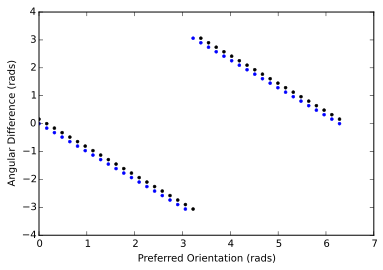

In [65]:
y1 = angdiff(phis[0], phis)
plot(phis, y1,'.b')
y2 = angdiff(phis[1], phis)
plot(phis, y2, '.k')
ylabel('Angular Difference (rads)')
xlabel('Preferred Orientation (rads)')